# Prototyping Hybrid deepface 

## 1. Mount Google Storage Bucket 

In [10]:
from google.colab import auth
auth.authenticate_user()

In [11]:
!echo "deb http://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
!apt -qq update
!apt -qq install gcsfuse

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2537  100  2537    0     0  70472      0 --:--:-- --:--:-- --:--:-- 70472
OK
39 packages can be upgraded. Run 'apt list --upgradable' to see them.
The following NEW packages will be installed:
  gcsfuse
0 upgraded, 1 newly installed, 0 to remove and 39 not upgraded.
Need to get 11.3 MB of archives.
After this operation, 24.0 MB of additional disk space will be used.
Selecting previously unselected package gcsfuse.
(Reading database ... 155222 files and directories currently installed.)
Preparing to unpack .../gcsfuse_0.37.0_amd64.deb ...
Unpacking gcsfuse (0.37.0) ...
Setting up gcsfuse (0.37.0) ...


In [12]:
!mkdir data
!gcsfuse --implicit-dirs diversity-in-cinema-735 data 

2021/11/23 21:38:04.713678 Start gcsfuse/0.37.0 (Go version go1.17.2) for app "" using mount point: /content/data
2021/11/23 21:38:04.723091 Opening GCS connection...
2021/11/23 21:38:05.405583 Mounting file system "diversity-in-cinema-735"...
2021/11/23 21:38:05.439432 File system has been successfully mounted.


In [13]:
# imports
import numpy as np
import pandas as pd
import os

from PIL import Image


from tensorflow.keras import layers, models, Sequential 
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import optimizers

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

## 2. Transfer Learning

In [1]:
! pip install deepface

     |████████████████████████████████| 61 kB 3.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 2.3 MB 12.2 MB/s 
  Created wheel for gdown: filename=gdown-4.2.0-py3-none-any.whl size=14273 sha256=456780d7f67361d728b89ca5e956d5d10e9f505b26784a976c822ba8c256f37d
  Stored in directory: /root/.cache/pip/wheels/8c/17/ff/58721d1fabdb87c21a0529948cf39e2be9af90ddbe4ad65944
Successfully built gdown
  Attempting uninstall: gdown
    Found existing installation: gdown 3.6.4
    Uninstalling gdown-3.6.4:
      Successfully uninstalled gdown-3.6.4


In [4]:
def get_labels():

  path = "data/data/training_data/train"

  df = pd.read_csv("data/data/training_data/fairface_label_train.csv")

  df["target"] = df["gender"] + "-" + df["race"]

  return df

In [5]:
def random_balanced_sample(dataframe, sample_size=5000, balance_on="target"):

  """
  function that given a dataframe returns a random balanced subsample balanced
  on a desired feature
  
  """

  classes = dataframe[balance_on].unique()
  number_of_classes = len(classes)

  sample_dfs = []
  for label in classes:

      df_class = dataframe[dataframe[balance_on] == label]
      sample = df_class.sample(int(sample_size/len(classes)))
      sample_dfs.append(sample)

  return pd.concat(sample_dfs, axis=0)


In [16]:
from tqdm import tqdm

def get_training_data():

    image_path = "data/data/training_data/train"

    labels = get_labels()
    labels = random_balanced_sample(labels, sample_size=30, balance_on="target")

    img_list = []

    for image_name in tqdm(labels["file"].values):
        img_path = os.path.join("data/data/training_data", image_name)
        image = np.array(Image.open(img_path).resize((152,152)))
        img_list.append(image)
    
    X = np.array(img_list)
    print(len(X))
    y = labels["target"].values
    #y_encoded = encode_labels(y)
    #y_cat = to_categorical(y_encoded)  
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [17]:
X_train, y_train, X_val, y_val, X_test, y_test = get_training_data()

100%|██████████| 28/28 [00:38<00:00,  1.36s/it]

28


In [18]:
from deepface import DeepFace

models = ["VGG-Face", "Facenet", "Facenet512", "OpenFace", "DeepFace", "DeepID", "ArcFace", "Dlib"]
backends = ['opencv', 'ssd', 'dlib', 'mtcnn', 'retinaface']

image_path = "data/data/training_data/train"

labels = get_labels()
labels = random_balanced_sample(labels, sample_size=30, balance_on="target")

img_list = []

for image_name in tqdm(labels["file"].values):
    img_path = os.path.join("data/data/training_data", image_name)
    img_list.append(img_path)

Directory  /root /.deepface created
Directory  /root /.deepface/weights created


100%|██████████| 28/28 [00:00<00:00, 80770.64it/s]


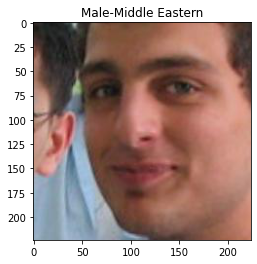

In [71]:
import matplotlib.pyplot as plt

i = 8
plt.imshow(Image.open(img_list[i]), cmap="gray")
plt.title(f"{labels['target'].iloc[i]}")
plt.show()


In [72]:
#facial analysis
DeepFace.analyze(img_path = img_list[i], detector_backend = backends[0], actions = ['gender', 'race'], enforce_detection=False)

Action: race: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]


{'dominant_race': 'middle eastern',
 'gender': 'Man',
 'race': {'asian': 0.08926926529966295,
  'black': 0.08912627235986292,
  'indian': 4.851662367582321,
  'latino hispanic': 14.245522022247314,
  'middle eastern': 64.20155763626099,
  'white': 16.52286648750305},
 'region': {'h': 224, 'w': 224, 'x': 0, 'y': 0}}